<a href="https://colab.research.google.com/github/ttknguyen/CS114.L22.KHCL/blob/master/CS114.L22.KHCL/tree/master/BaiTapColab/Bai3/final_score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bài tập colab: Dự đoán điểm cuối kỳ của sinh viên**

Thành viên:
  - Thái Trần Khánh Nguyên - 19520188
  - Nguyễn Khánh Như - 19520209
  - Đoàn Nguyễn Nhật Quang - 19520235

# Import Libraries

In [76]:
import pandas as pd
import numpy as np
import sklearn
import gdown
import math

import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn import utils

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm

# Get & read data

- Nhóm em sử dụng thư viện gdown để download dữ liệu từ google drive thông qua id của file.

In [3]:
# Download dữ liệu của file wecode.csv
gdown.download("https://drive.google.com/uc?id=1XNFKxi6y5l6ikrXixZjeQRiWOHYE1FhC", 'wecode.csv', quiet=False)

# Download dữ liệu của file score-training.csv
gdown.download("https://drive.google.com/uc?id=1qelheHJLdNfcu-VcHmC0xPmt2vgeLjpX", 'score_training.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XNFKxi6y5l6ikrXixZjeQRiWOHYE1FhC
To: /content/wecode.csv
30.8MB [00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qelheHJLdNfcu-VcHmC0xPmt2vgeLjpX
To: /content/score_training.csv
100%|██████████| 23.9k/23.9k [00:00<00:00, 6.29MB/s]


'score_training.csv'

In [35]:
# Đọc 2 file vừa download  
dataWecode = pd.read_csv("/content/wecode.csv")
dataScore_training = pd.read_csv("/content/score_training.csv")

In [5]:
# Kiểm tra file wecode.csv
dataWecode

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07
...,...,...,...,...,...,...,...,...,...,...,...,...
264601,266667,0,25,1796,0,SCORE,0,100,solution-3977,4,2021-04-28 09:34:20,2021-04-28 09:34:27
264602,266668,0,25,1796,0,Compilation Error,0,100,solution-3978,2,2021-04-28 09:35:07,2021-04-28 09:35:08
264603,266669,0,25,1796,1,SCORE,10000,100,solution-3979,4,2021-04-28 09:35:15,2021-04-28 09:35:21
264604,266670,0,150,255,1,SCORE,6250,100,solution-3980,2,2021-05-11 01:34:57,2021-05-11 01:35:28


In [6]:
dataWecode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


In [7]:
# Kiểm tra file score_training.csv và đổi tên column id thành user_id cho khớp với file wecode.csv để thuận tiện cho việc gộp dữ liệu sau này
dataScore_training.rename(columns={'id':'user_id'}, inplace=True)
dataScore_training

,user_id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5,4.5,10,4,6,6.03
971,1859,8,5,10,1.5,5.4,5.06
972,1862,5,6.5,1,7.5,5.1,4.71
973,1865,6.5,,3,7.5,,6.89


In [8]:
dataScore_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  975 non-null    int64 
 1   QT       973 non-null    object
 2   GK       974 non-null    object
 3   TH       974 non-null    object
 4   CK       974 non-null    object
 5   TBM      974 non-null    object
 6   TBTL     974 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.4+ KB


# Preprocessing

## Lấy những cột có dữ liệu cần thiết

-Theo như yêu cầu của đề bài thì chúng ta sẽ dự đoán điểm cuối kỳ của sinh viên thông qua việc làm bài trên wecode thế nên nhóm em sẽ lấy dữ liệu của điểm CK để tiến hành dự đoán

In [9]:
dataScore_training = dataScore_training[['user_id', 'CK']]
dataScore_training

,user_id,CK
0,22,8.5
1,24,9.5
2,27,10
3,28,9.5
4,29,8.5
...,...,...
970,1857,4
971,1859,1.5
972,1862,7.5
973,1865,7.5


## Tính toán những thông tin cần cho model

-Nhóm em dự đoán điểm cuối kỳ thông qua các chỉ số thể hiện mức độ chuyên cần của sinh viên trong quá trình làm wecode:
  - Số bài tập đã giải được
  - Số bài tập đã hoàn thành (score = 100000)
  - Số lần nộp bài của sinh viên
  - Số assignment sinh viên đã thử làm bài
  - Tổng điểm trên wecode

In [10]:
#Đếm các problem đã hoàn thành 
def Solved_Problem(data):
  if data['is_final'] == 1 and data['pre_score'] == 10000:
    return 1
  return 0

In [11]:
dataWecode['solved_problem'] = dataWecode.apply(Solved_Problem,axis=1)

In [12]:
groupByUserId = dataWecode.groupby(by='user_id', sort= True)

In [13]:
data = pd.DataFrame({
    # Số assignment đã làm thử 
    'assignment_tries': groupByUserId['assignment_id'].nunique(),  
    # Số problem đã làm thử 
    'problem_tries': groupByUserId['problem_id'].nunique(),
    # Số problem đã hoàn thành 
    'completed_problem': groupByUserId['solved_problem'].apply(lambda x: (x==1).sum()),
    # Số lần submit 
    'submit_count': groupByUserId['problem_id'].count(),
    # Số lần pre_score = 10000 
    'total_pre_score': groupByUserId['pre_score'].apply(lambda x: (x==10000).sum()),
    # Tổng điểm
    'total_score': groupByUserId.apply(lambda x: x[x['is_final'] == 1]['pre_score'].sum())
})

data

,assignment_tries,problem_tries,completed_problem,submit_count,total_pre_score,total_score
user_id,,,,,,
1,1,2,1,2,1,10000
4,1,41,37,54,44,370000
5,4,5,3,6,3,30000
6,4,88,85,130,89,850000
7,1,2,0,5,0,9209
...,...,...,...,...,...,...
1860,10,43,28,76,29,329665
1862,2,6,4,12,4,40000
1864,5,63,28,187,30,439741


In [14]:
data = pd.merge(data, dataScore_training, how='left', on=['user_id'])

## Xử lý missing data

In [15]:
#Kiểm tra xem dữ liệu có bị thiếu hay không
data.isna()

,user_id,assignment_tries,problem_tries,completed_problem,submit_count,total_pre_score,total_score,CK
0,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...
1154,False,False,False,False,False,False,False,True
1155,False,False,False,False,False,False,False,False
1156,False,False,False,False,False,False,False,True
1157,False,False,False,False,False,False,False,False


In [16]:
check = list(data['CK'])
unique, counts = np.unique(check, return_counts=True)
print(dict(zip(unique, counts)))

{'0': 20, '0.5': 3, '1': 6, '1.5': 6, '10': 2, '2': 10, '2.5': 24, '3': 22, '3.5': 28, '4': 43, '4.5': 43, '5': 46, '5.5': 54, '6': 55, '6.5': 61, '7': 68, '7.5': 85, '8': 88, '8.5': 65, '9': 52, '9.5': 25, 'nan': 307, '\xa0': 46}


Sau khi kiểm tra thì ở cột cuối kỳ ngoài dạng missing data Nan thì còn có dạng là '\xa0'. Để có thể xử lý được thì nhóm em sẽ đưa dạng '\xa0' về Nan.

In [17]:
for i in range(data.shape[0]):
  if (data['CK'][i] == '\xa0'):
    data['CK'][i] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data.describe()

,user_id,assignment_tries,problem_tries,completed_problem,submit_count,total_pre_score,total_score
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1.159000e+03
mean,986.791199,10.668680,83.856773,82.253667,228.305436,86.143227,8.475944e+05
std,541.723042,6.650202,48.823058,52.006920,162.823765,55.046504,5.316463e+05
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00
25%,520.500000,7.000000,47.000000,44.000000,102.500000,46.000000,4.500000e+05
50%,984.000000,11.000000,84.000000,80.000000,197.000000,83.000000,8.193600e+05
75%,1464.500000,14.000000,102.000000,103.500000,317.000000,110.000000,1.061826e+06
max,1868.000000,36.000000,212.000000,314.000000,1359.000000,331.000000,3.168763e+06


In [19]:
#Loại bỏ các bộ dữ liệu bị NaN ở cột CK để những bộ đó sau khi hoàn thành model sẽ dự đoán sau
dataTrain = data.dropna()
dataTrain['CK'] = pd.to_numeric(dataTrain['CK'], errors='coerce' )
dataTrain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,assignment_tries,problem_tries,completed_problem,submit_count,total_pre_score,total_score,CK
9,24,15,78,72,164,80,750299,9.5
10,27,2,5,3,13,4,39000,10.0
11,29,13,80,72,199,75,762760,8.5
13,34,11,84,81,218,81,822888,6.5
14,35,25,147,145,297,152,1477000,4.5
...,...,...,...,...,...,...,...,...
1151,1856,5,31,23,64,23,270790,7.5
1152,1857,6,34,37,55,37,386000,4.0
1153,1859,7,27,3,31,3,39000,1.5
1155,1862,2,6,4,12,4,40000,7.5


# Visualize 

Vẽ các đồ thị liên quan đến bài toán này

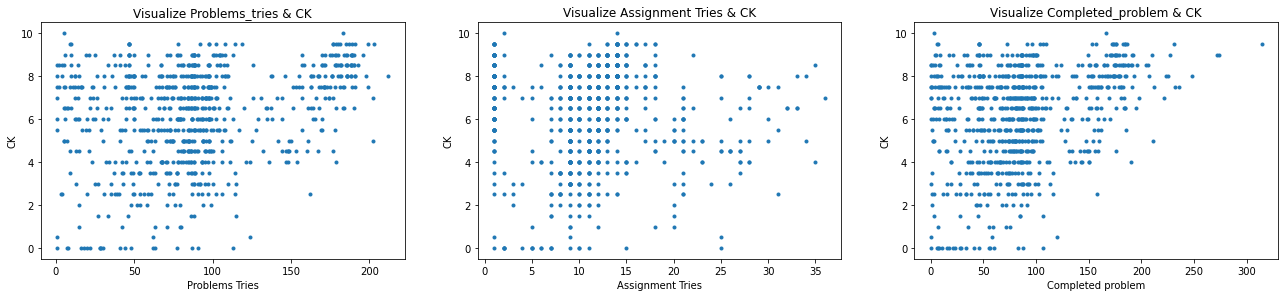

In [20]:
plt.figure(figsize = (30, 20))

# Visualize giữa problemsTries và CK
plt.subplot(4, 4, 1)
plt.plot(dataTrain['problem_tries'], dataTrain['CK'], '.')
plt.xlabel('Problems Tries')
plt.ylabel('CK')
plt.title('Visualize Problems_tries & CK')

# Visualize giữa assignment_tries và CK
plt.subplot(4, 4, 2)
plt.plot(dataTrain['assignment_tries'], dataTrain['CK'], '.')
plt.xlabel('Assignment Tries')
plt.ylabel('CK')
plt.title('Visualize Assignment Tries & CK')

# Visualize giữa assignment_tries và CK
plt.subplot(4, 4, 3)
plt.plot(dataTrain['completed_problem'], dataTrain['CK'], '.')
plt.xlabel('Completed problem')
plt.ylabel('CK')
plt.title('Visualize Completed_problem & CK')

plt.show()

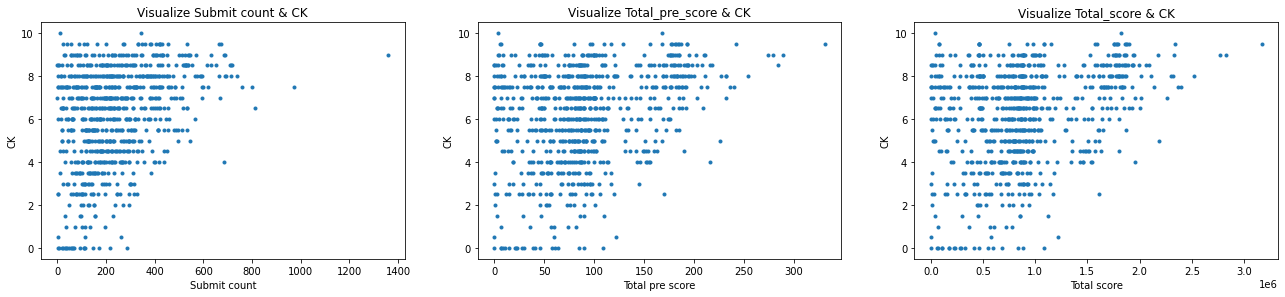

In [21]:
plt.figure(figsize = (30, 20))

# Visualize giữa problemsTries và CK
plt.subplot(4, 4, 1)
plt.plot(dataTrain['submit_count'], dataTrain['CK'], '.')
plt.xlabel('Submit count')
plt.ylabel('CK')
plt.title('Visualize Submit count & CK')

# Visualize giữa assignment_tries và CK
plt.subplot(4, 4, 2)
plt.plot(dataTrain['total_pre_score'], dataTrain['CK'], '.')
plt.xlabel('Total pre score')
plt.ylabel('CK')
plt.title('Visualize Total_pre_score & CK')

# Visualize giữa assignment_tries và CK
plt.subplot(4, 4, 3)
plt.plot(dataTrain['total_score'], dataTrain['CK'], '.')
plt.xlabel('Total score')
plt.ylabel('CK')
plt.title('Visualize Total_score & CK')

plt.show()

# Solving Problem

## Split data set

Chia tập data set làm 2 phần: 1 phần dể train model và 1 phần để kiểm tra độ chính xác của model

In [22]:
X = dataTrain[['assignment_tries',	'problem_tries',	'completed_problem',	'submit_count',	'total_pre_score',	'total_score']]
Y = dataTrain['CK']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

## Linear Regression

-Trước tiên, nhóm em sẽ thử sử dụng mô hình Linear Regression để dự đoán điểm cuối kỳ

In [24]:
CK_lr = LinearRegression().fit(X_train, y_train)
CK_lr.intercept_ , CK_lr.coef_

(5.520555897055645,
 array([-1.24412445e-01, -9.56053542e-03, -1.00719242e-01,  2.44710788e-03,
         4.52405131e-03,  1.18776868e-05]))

In [25]:
y_pred = CK_lr.predict(X_train)
mse = sklearn.metrics.mean_squared_error(y_train, y_pred)
print("MSE of Data Train:", mse)

MSE of Data Train: 4.058750803393181


In [26]:
# Tính trung bình cộng thời gian chạy của Data Test
print("Average of y_test:", np.average(y_test))

# Mean Square Error of Data Test 
y_pred = CK_lr.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print("MSE of Data Test:", mse)

error = math.sqrt(mse) / np.average(y_test)
print("Error(%):", error*100)

Average of y_test: 6.2592592592592595
MSE of Data Test: 3.8293461583613726
Error(%): 31.263627885649054


## Support Vector Machine

Ngoài mô hình Linear Regression ở trên, nhóm em còn thử thêm một phương pháp khác là Support Vector Machine để xem có hiệu quả hay không

In [32]:
CK_svm = svm.SVR().fit(X_train, y_train)

In [33]:
# Tính trung bình cộng thời gian chạy của Data Test
print("Average of y_test:", np.average(y_test))

# Mean Square Error of Data Test 
y_pred_svm = CK_svm.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred_svm)
print("MSE of Data Test:", mse)

error = math.sqrt(mse) / np.average(y_test)
print("Error(%):", error*100)

Average of y_test: 6.2592592592592595
MSE of Data Test: 4.447715119229711
Error(%): 33.69345453514848


# Link tham khảo

**Link tham khảo**:
  - Xử lý dữ liệu: https://pandas.pydata.org/pandas-docs/stable/reference/frame.html
  - Working missing data: https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
  - Mô hình Linear Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
  - Mô hình SVM: https://scikit-learn.org/stable/modules/svm.html